In [1]:
import numpy as np
import random

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

from keras.datasets import mnist

/home/hmenn/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Load MNIST dataset and flatten image
(6000,28,28) -> (6000, 784)

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]* x_train.shape[2])

print('Train Shape:',x_train.shape)
print('Class Shape:',y_train.shape)

Train Shape: (60000, 784)
Class Shape: (60000,)


## PART 1 - Implement PCA function

In [3]:
def pca(X):
    X_std = X #StandardScaler().fit_transform(X)
    
    mean_vec = np.mean(X_std, axis=0)
    
    cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
    
    
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    #print('Eigenvectors \n',eig_vecs.shape)
    #print('\nEigenvalues \n',eig_vals.shape)
    
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

    
    # extract 4 princible component
    matrix_w = np.hstack((eig_pairs[0][1].reshape(784,1), 
                      eig_pairs[1][1].reshape(784,1),
                      eig_pairs[2][1].reshape(784,1),
                      eig_pairs[3][1].reshape(784,1)))
    
    Y = X_std.dot(matrix_w)
    
    Y[:,0] *= -1
    
    return mean_vec, eig_vals, Y
    
#mean_vec, eig_vals, pc_vectors = pca(x_train)   
# print('Covariance matrix \n',cov_mat.shape)
#print('Eigenvectors \n',eig_vecs.shape)
#print('\nEigenvalues \n',eig_vals.shape)

## PART 2 - USE PCA

Train 1000 random value from MNIST dataset. 

In [4]:
randomOrder = np.arange(x_train.shape[0])
np.random.shuffle(randomOrder)

trainSetX = x_train[randomOrder[:1000]]
trainSetY = y_train[randomOrder[:1000]]

mean_vector, eig_vals, pc_vectors = pca(trainSetX)

#### Princible Component 0 - 1 on MNIST[:1000] dataset

It's very similar to SKLearn PCA result which shown belown

/home/hmenn/.local/lib/python3.6/site-packages/numpy/core/numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


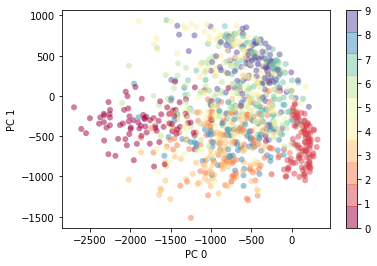

In [5]:
plt.scatter(pc_vectors[:, 0],pc_vectors[:, 1],
            c=trainSetY, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('PC 0')
plt.ylabel('PC 1')
plt.colorbar();

#### Princible Component 0 - 2 on MNIST[:1000] dataset

/home/hmenn/.local/lib/python3.6/site-packages/numpy/core/numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


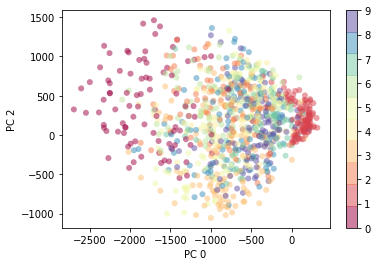

In [6]:
plt.scatter(pc_vectors[:, 0],pc_vectors[:, 2],
            c=trainSetY, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('PC 0')
plt.ylabel('PC 2')
plt.colorbar();

#### Princible Component 0 - 3 on MNIST[:1000] dataset

/home/hmenn/.local/lib/python3.6/site-packages/numpy/core/numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


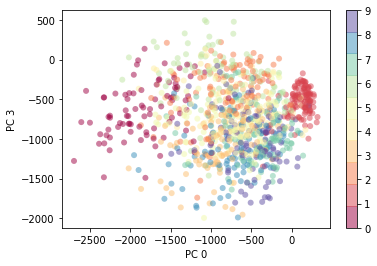

In [7]:
plt.scatter(pc_vectors[:, 0],pc_vectors[:, 3],
            c=trainSetY, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('PC 0')
plt.ylabel('PC 3')
plt.colorbar();

#### Princible Component 1 - 2 on MNIST[:1000] dataset

/home/hmenn/.local/lib/python3.6/site-packages/numpy/core/numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


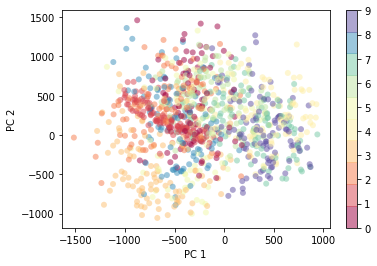

In [8]:
plt.scatter(pc_vectors[:, 1],pc_vectors[:, 2],
            c=trainSetY, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar();

### PCA from SKLearn for test

Offical PCA Algorithm. I got similar values with PC0-1

(1000, 784)
(1000, 2)


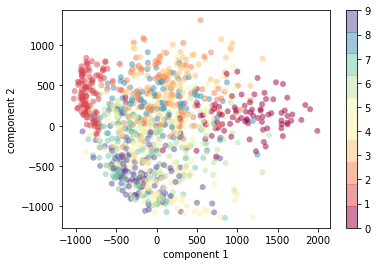

In [9]:
from sklearn.decomposition import PCA as skPCA

skPca = skPCA(2)  # project from 64 to 2 dimensions
projected = skPca.fit_transform(trainSetX)
print(trainSetX.shape)
print(projected.shape)

plt.scatter(projected[:, 0],projected[:, 1], #[0 for i in range(len(projected))]
            c=trainSetY, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

### Testing PCA with Random Forest Decision Tree

In this part, I applied PCA on all mnist dataset. After getting
Principle Components, RandomForestClassifier works with KFold Validation

RandomForest without PCA gave %53-56 accuracy

#### Princible Component 0 - 1 on MNIST[:1000] dataset

In [10]:
kf = KFold(n_splits=5)

# use all mnist dataset
mean, eigVals, pc_vectors = pca(x_train)

for trainIndex, testIndex in kf.split(pc_vectors):
    
    kTrainX, kTestX = pc_vectors[trainIndex], pc_vectors[testIndex]
    kTrainY, kTestY = y_train[trainIndex], y_train[testIndex]
        
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf.fit(kTrainX, kTrainY)
    
    predicts = clf.predict(kTestX)
    
    print('Accuracy Score:', accuracy_score(predicts, kTestY))
    

/home/hmenn/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/home/hmenn/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


Accuracy Score: 0.4563333333333333


/home/hmenn/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


Accuracy Score: 0.43133333333333335


/home/hmenn/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


Accuracy Score: 0.42583333333333334


/home/hmenn/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


Accuracy Score: 0.44816666666666666
Accuracy Score: 0.46775


/home/hmenn/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


## PART3 - Non-Linear PCA

Test Non-Linear Kernal PCA on first MNIST dataset (1000 row)

Non-Linear PCA gets about %40 accuracy score. When we test on our linear PCA, we get about %45 accuracy.
On the other hand SKLearn Linear PCA get %55 accuracy score.

In [11]:
from sklearn.decomposition import KernelPCA

kf = KFold(n_splits=5)

kernelPCA = KernelPCA(4)
projected = kernelPCA.fit_transform(trainSetX)

for trainIndex, testIndex in kf.split(projected):
        
    kTrainX, kTestX = projected[trainIndex], projected[testIndex]
    kTrainY, kTestY = trainSetY[trainIndex], trainSetY[testIndex]
            
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf.fit(kTrainX, kTrainY)
    
    predicts = clf.predict(kTestX)
    
    print('Accuracy Score:', accuracy_score(predicts, kTestY))

Accuracy Score: 0.305
Accuracy Score: 0.355
Accuracy Score: 0.45
Accuracy Score: 0.395
Accuracy Score: 0.385


Draw scatter of KernelPCA. As you can see we got almost same with linear PCA but axises are reversed.

#### Component 0 - 1

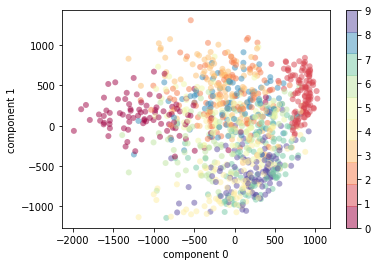

In [12]:
plt.scatter(projected[:, 0],projected[:, 1], #[0 for i in range(len(projected))]
            c=trainSetY, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.colorbar();

#### Component 0 - 2

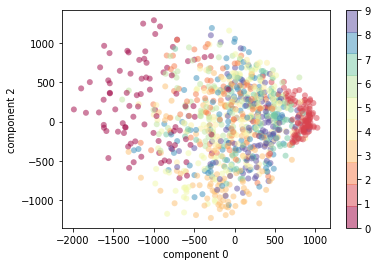

In [13]:
plt.scatter(projected[:, 0],projected[:, 2], #[0 for i in range(len(projected))]
            c=trainSetY, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 0')
plt.ylabel('component 2')
plt.colorbar();

#### Component 0 - 3

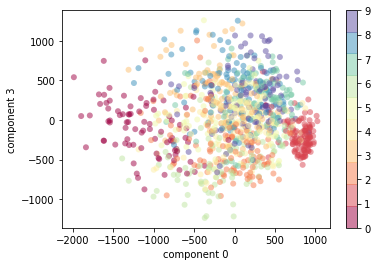

In [14]:
plt.scatter(projected[:, 0],projected[:, 3], #[0 for i in range(len(projected))]
            c=trainSetY, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 0')
plt.ylabel('component 3')
plt.colorbar();

#### Component 1 - 2

Component 1-2 of KernelPCA and our PCA results are almost same. There is some different points and axis reserves.

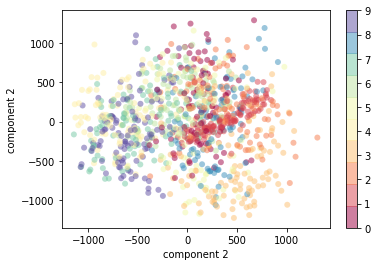

In [15]:
plt.scatter(projected[:, 1],projected[:, 2], #[0 for i in range(len(projected))]
            c=trainSetY, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 2')
plt.ylabel('component 2')
plt.colorbar();

In [16]:
import gc
gc.collect()

7719